In [112]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as sts

matplotlib.rcParams['font.family'] = 'fantasy'
import warnings
warnings.filterwarnings("ignore")

In [113]:
h = pd.read_csv('df_result.csv')

In [114]:
h.Okrug.unique()

array(['Северный административный округ', 'Южный административный округ',
       'Северо-Восточный административный округ',
       'Восточный административный округ',
       'Северо-Западный административный округ',
       'Западный административный округ',
       'Центральный административный округ',
       'Юго-Западный административный округ',
       'Юго-Восточный административный округ',
       'Новомосковский административный округ',
       'Зеленоградский административный округ'], dtype=object)

In [115]:
# делаем onehot encoding, чтобы качественные признаки можно было использовать
n = h

h.drop('metro', axis = 1, inplace=True) 
okr = np.array(h.Okrug.unique())
for i in range(len(okr)):
    h[f'{okr[i]}'] = (h.Okrug == okr[i])*1
h.drop('Okrug', axis = 1, inplace=True)    

# переименуем для удобства отображения
h.rename(columns = {'Северный административный округ':'САО', 'Южный административный округ':'ЮАО',
                   'Северо-Восточный административный округ':'СВАО',
       'Восточный административный округ':'ВАО',
       'Северо-Западный административный округ':'СЗАО',
       'Западный административный округ':'ЗАО',
       'Центральный административный округ':'ЦАО',
       'Юго-Западный административный округ':'ЮЗАО',
       'Юго-Восточный административный округ':'ЮВАО',
       'Новомосковский административный округ':'НАО',
       'Зеленоградский административный округ':'ЗелАО'}, inplace = True )


toh = np.array(h['type of house'].unique())
for i in range(len(toh)):
    h[f'{toh[i]}'] = (h['type of house'] == toh[i])*1
h.drop('type of house', axis = 1, inplace=True) 

In [116]:
toe = np.array(h['type of elevators'].unique())
for i in range(len(toe)):
    h[f'{toe[i]}'] = (h['type of elevators'] == toe[i])*1
h.drop('type of elevators', axis = 1, inplace=True) 


r = np.array(h['readiness'].unique())
for i in range(len(r)):
    h[f'{r[i]}'] = (h['readiness'] == r[i])*1
h.drop('readiness', axis = 1, inplace=True) 

Теперь, когда  мы перевели качественные переменные через onehotkey в числовые, займёмся выбросами. Попробуем способ с нормальным распределением с кодкампа https://www.codecamp.ru/blog/remove-outliers-python/

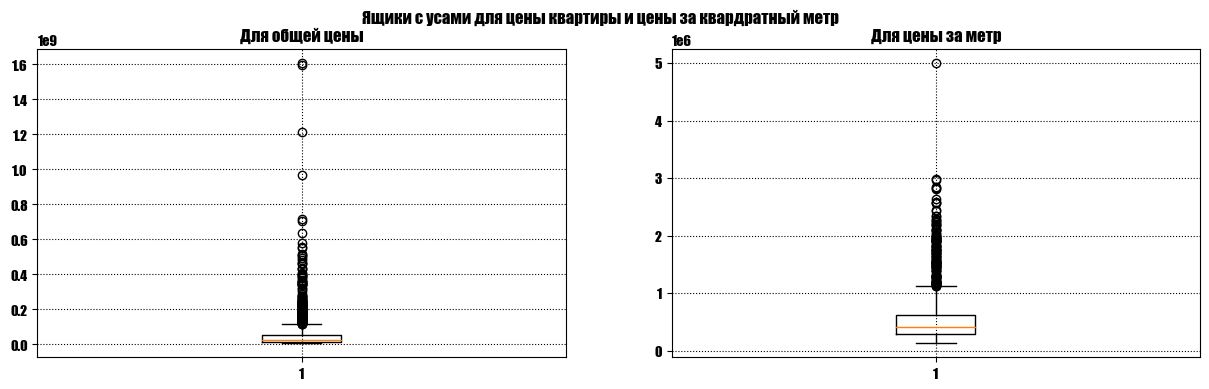

In [117]:
fig= plt.subplots(nrows = 1, ncols = 2, sharex = 'none',figsize=(15,4))
plt.suptitle("Ящики с усами для цены квартиры и цены за квардратный метр")

plt.subplot(121)
plt.title("Для общей цены")
plt.grid(axis = 'both', color = 'black', linestyle=':')
plt.boxplot(x = h['price(rub)'])

plt.subplot(122)
plt.title("Для цены за метр")
plt.grid(axis = 'both', color = 'black', linestyle=':')
plt.boxplot(x = h['ppm(rub)'])

plt.show()

In [118]:
z = np.abs(sts.zscore(h))
h_clean_1 = h[(z<3).all(axis=1)]
h.shape, h_clean_1.shape

((1485, 36), (498, 36))

Подобным образом мы удалили $\frac{2}{3}$ наших данных, что неудовлетворительно с учётом того, что всего данных и так не очень много. Метод межквартильного диапазона обычно точнее z-метода, следовательно, скорее всего, он отрежет от наших данных ещё больше наблюдений, чего мы не можем себе позволить. Будем говорить не о "выбросах", а о далеко отстоящих от основной массы наблюдений включаемых в рынок точках

Построим две одинаковые простейшие модели (линейные регрессии), в одной будем таргетировать цену на квардратный метр, в другой - просто цену (в соответствующих моделях противоположные таргеты, само собой, удалим, а то с общим метражом мы выдаём модели слишком много данных)

На всякий случай модели с не удалёнными противоположными таргетами мы тоже прогоним на случай, если вдруг сможем поймать парадокс. Стоит помнить, что пока мы ничего не скалируем и вообще очень мало что умного с данными делаем не потому, что не понимаем, как, а потому, что при общей природе обоих таргетов преобразования могут сгладить те их недостатки, которые мы пытаемся обнаружить.

In [119]:
# импортируем всякие штучки для машинки (тут даже спойлеры!)
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
import sklearn.preprocessing as pp
from sklearn.model_selection import GridSearchCV

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
Получив такое предупреждение при попытке использовать stratify = h['price(rub)'], узнаём, что получить трейн/тест сплит таким, чтобы выборки сохраняли распределение, не выйдет. смиряемся

На самом деле эта тема соседствует с темой про выбросы в выборке: так как мы рассматриваем не абстрактную цену, которую назначила психология рынка или что-то подобное, удалять выбросы почти эквивалентно обеднению данных. При этом нужно понимать, что выбросы в выборке есть и, если мы магическим образом не найдём какую-то группу параметров, которые чудом определяют результирующий признак полностью, модель будет ошибаться. И будет ошибаться сильно.



# Скоринг моделей


Несколько слов о том, как мы будем штрафовать и оценивать. И как будем интерпретировать оценки. Мы рассматриваем цену в качестве таргетируемого признака. И эта цена на квартиры, где +- 100к -- не деньги. Поэтому, куда важнее для нас фиксировать случаи, когда предсказанная цена отклоняется от реальной сильно. Мы возьмём MSE как скоринг и метод оценки. Модели будем сравнивать между собой по его величине, учитывая, конечно, специфику нормализации

In [120]:
# общая цена как таргет, отделяем на тест 20% выборки
h1_train, h1_test = train_test_split(h, test_size=0.2, random_state=13)

y1_test = h1_test['price(rub)']
x1_test = h1_test.drop(['price(rub)', 'ppm(rub)'], axis = 1)

y1_train = h1_train['price(rub)']
x1_train = h1_train.drop(['price(rub)', 'ppm(rub)'], axis = 1)

In [121]:
# сразу будем ходить по гриду на случай, если дефолтные параметры не оптимальны
model_1 = LinearRegression(n_jobs = -1)
test_1 = GridSearchCV(model_1, param_grid= {'fit_intercept':[True, False],
                                           'copy_X':[True, False],
                                           'positive': [True, False],
                                            'normalize':[True, False]},
                     scoring = 'neg_mean_squared_error')

test_1.fit(x1_train, y1_train)
test_1.best_params_, test_1.best_score_

({'copy_X': True,
  'fit_intercept': True,
  'normalize': False,
  'positive': False},
 -3053796306348173.0)

In [122]:
model_11 = LinearRegression(n_jobs = -1,copy_X=True,
  fit_intercept=True,
  normalize=False,
  positive=False)
model_11.fit(x1_train, y1_train)
y1_pred = model_11.predict(x1_test)
mse_1 = metrics.mean_squared_error(y1_test, y1_pred)
print(f'MSE = {mse_1}')
g = h['price(rub)'].mean()
print(f'Mean price = {g}')

MSE = 1974543306524315.5
Mean price = 59665614.239057235


In [123]:
# цена за метр как таргет, отделяем на тест 20% выборки
h2_train, h2_test = train_test_split(h, test_size=0.2, random_state=13)

y2_test = h2_test['ppm(rub)']
x2_test = h2_test.drop(['price(rub)', 'ppm(rub)'], axis = 1)

y2_train = h2_train['ppm(rub)']
x2_train = h2_train.drop(['price(rub)', 'ppm(rub)'], axis = 1)

In [124]:
model_2 = LinearRegression(n_jobs = -1)
test_2 = GridSearchCV(model_2, param_grid= {'fit_intercept':[True, False],
                                           'copy_X':[True, False],
                                           'positive': [True, False],
                                            'normalize':[True, False]},
                     scoring = 'neg_mean_squared_error')

test_2.fit(x2_train, y2_train)
test_2.best_params_, test_2.best_score_


({'copy_X': True,
  'fit_intercept': False,
  'normalize': True,
  'positive': False},
 -72029608321.0082)

In [125]:
model_21 = LinearRegression(n_jobs = -1,copy_X=True,
  fit_intercept=False,
  normalize=True,
  positive=False)
model_21.fit(x2_train, y2_train)
y2_pred = model_21.predict(x2_test)
mse_2 = metrics.mean_squared_error(y2_test, y2_pred)
f = h['ppm(rub)'].mean()
print(f'MSE = {mse_2}')
print(f'Mean meter price = {f}')

MSE = 74242672185.06511
Mean meter price = 560319.3845117845


In [126]:
print('корень из отношения средних квадратичных ошибок (при условии, что наши тесты одинаково эффективны, должен равняться метражу)')
display(np.sqrt(mse_1/mse_2))
print('средний метраж')
display(h['total area(м²)'].mean())

корень из отношения средних квадратичных ошибок (при условии, что наши тесты одинаково эффективны, должен равняться метражу)


163.08218975269966

средний метраж


81.4626127946128

Итого: на простейшей модели можем понять, что таргетировать общую площадь будет не так удачно, как цену за метр. Логически это тоже оправдано, потому что мы не классифицируем жильё по доступности, а именно стараемся "угадать" стоимость жилья. При верном предсказании цены за метр и наличии информации о метраже, нам это удасться.

In [127]:
# подготавливаем изменённый датафрейм, с этими данными мы уже будем дальше работать
# на всякий случай организуем два самых базовых скелера

mm_x = pp.MinMaxScaler()
ss_x = pp.StandardScaler()
mm_y = pp.MinMaxScaler()
ss_y = pp.StandardScaler()


h3 = h.drop('price(rub)', axis = 1)
h3_train, h3_test = train_test_split(h3, test_size=0.2, random_state=13)


y3_train = h3_train['ppm(rub)']
y3_train_mm = mm_y.fit_transform(np.array(h3_train['ppm(rub)']).reshape(-1, 1))
y3_train_ss = ss_y.fit_transform(np.array(h3_train['ppm(rub)']).reshape(-1, 1))

x3_train = h3_train.drop(['ppm(rub)'], axis = 1)
x3_train_mm = mm_x.fit_transform(h3_train.drop(['ppm(rub)'], axis = 1))
x3_train_ss = ss_x.fit_transform(h3_train.drop(['ppm(rub)'], axis = 1))

y3_test = h3_test['ppm(rub)']
y3_test_mm = mm_y.transform(np.array(h3_test['ppm(rub)']).reshape(-1, 1))
y3_test_ss = ss_y.transform(np.array(h3_test['ppm(rub)']).reshape(-1, 1))

x3_test = h3_test.drop(['ppm(rub)'], axis = 1)
x3_test_mm = mm_x.transform(h3_test.drop(['ppm(rub)'], axis = 1))
x3_test_ss = ss_x.transform(h3_test.drop(['ppm(rub)'], axis = 1))

In [128]:
# линейная регрессия с minmax
model_311 = LinearRegression(n_jobs = -1)
test_311 = GridSearchCV(model_311, param_grid= {'fit_intercept':[True, False],
                                           'copy_X':[True, False],
                                           'positive': [True, False],
                                            'normalize':[True, False]},
                     scoring = 'neg_mean_squared_error')

test_311.fit(x3_train_mm, y3_train_mm)
display(test_311.best_params_, test_311.best_score_)

{'copy_X': True, 'fit_intercept': True, 'normalize': True, 'positive': False}

-0.003037707685105231

In [129]:
model_312 = LinearRegression(n_jobs = -1)
test_312 = GridSearchCV(model_312, param_grid= {'fit_intercept':[True, False],
                                           'copy_X':[True, False],
                                           'positive': [True, False],
                                            'normalize':[True, False]},
                     scoring = 'neg_mean_squared_error')

test_312.fit(x3_train_ss, y3_train_mm)
display(test_312.best_params_, test_312.best_score_)
print(f'{test_312.best_score_>test_311.best_score_} линейная регрессия с стандарт скэлером оказалась менее эффективной, чем с minmax')


{'copy_X': True, 'fit_intercept': True, 'normalize': False, 'positive': False}

-0.00304060880424894

False линейная регрессия с стандарт скэлером оказалась менее эффективной, чем с minmax


In [130]:
model_320 = KNeighborsRegressor()
test_320 = GridSearchCV(model_320, param_grid = {'weights':['uniform', 'distance'],
                                             'algorithm' :['auto', 'ball_tree', 'kd_tree', 'brute']},
                                             scoring = 'neg_mean_squared_error')
test_320.fit(x3_train, y3_train)
test_320.best_params_, abs(test_320.best_score_), mse_2

({'algorithm': 'ball_tree', 'weights': 'distance'},
 108548801735.4708,
 74242672185.06511)

In [131]:
model_321 = KNeighborsRegressor()
test_321 = GridSearchCV(model_321, param_grid = {'weights':['uniform', 'distance'],
                                             'algorithm' :['auto', 'ball_tree', 'kd_tree', 'brute']},
                                             scoring = 'neg_mean_squared_error')
test_321.fit(x3_train_mm, y3_train_mm)
test_321.best_params_, test_321.best_score_,test_312.best_score_
# нашим новым лучшим результатом становится test_321

({'algorithm': 'ball_tree', 'weights': 'distance'},
 -0.0024288745069656354,
 -0.00304060880424894)

In [132]:
model_322 = KNeighborsRegressor()
test_322 = GridSearchCV(model_322, param_grid = {'weights':['uniform', 'distance'],
                                             'algorithm' :['auto', 'ball_tree', 'kd_tree', 'brute']},
                                             scoring = 'neg_mean_squared_error')
test_322.fit(x3_train_ss, y3_train_ss)
test_322.best_params_, test_322.best_score_,test_321.best_score_

({'algorithm': 'ball_tree', 'weights': 'distance'},
 -0.21655914794962866,
 -0.0024288745069656354)

На данный момент оптимальной моделью является Kneighbours регрессия с minmax скэлером

In [133]:
model_331 = Lasso()
test_331 = GridSearchCV(model_331, param_grid = {'fit_intercept':[True, False],
                                             'precompute' :[True, False],
                                                'copy_X':[True, False],
                                                'warm_start': [True, False],
                                                'positive': [True, False],
                                                'selection':['cyclic', 'random']},
                                             scoring = 'neg_mean_squared_error')
test_331.fit(x3_train_mm, y3_train_mm)
test_331.best_params_, test_331.best_score_,test_321.best_score_

({'copy_X': True,
  'fit_intercept': True,
  'positive': True,
  'precompute': True,
  'selection': 'cyclic',
  'warm_start': True},
 -0.00868307821788097,
 -0.0024288745069656354)

In [134]:
#попробуем аппроксимировать полиномиальным способом
quad = pp.PolynomialFeatures(degree=2)
cub = pp.PolynomialFeatures(degree=3)

x3_train_q = quad.fit_transform(h3_train.drop(['ppm(rub)'], axis = 1))
x3_train_c = cub.fit_transform(h3_train.drop(['ppm(rub)'], axis = 1))

x3_test_q = quad.transform(h3_test.drop(['ppm(rub)'], axis = 1))
x3_test_c = cub.transform(h3_test.drop(['ppm(rub)'], axis = 1))


model_332 = KNeighborsRegressor()
test_332 = GridSearchCV(model_332, param_grid = {'weights':['uniform', 'distance'],
                                             'algorithm' :['auto', 'ball_tree', 'kd_tree', 'brute']},
                                             scoring = 'neg_mean_squared_error')
test_332.fit(x3_train_q, y3_train)
test_332.best_params_, abs(test_332.best_score_),mse_2

({'algorithm': 'auto', 'weights': 'distance'},
 107524244545.84819,
 74242672185.06511)

In [135]:
model_333 = KNeighborsRegressor(n_jobs=-1)
test_333 = GridSearchCV(model_332, param_grid = {'weights':['uniform', 'distance'],
                                             'algorithm' :['auto', 'ball_tree', 'kd_tree', 'brute']},
                                             scoring = 'neg_mean_squared_error')
test_333.fit(x3_train_c, y3_train)
test_333.best_params_, abs(test_333.best_score_),mse_2

({'algorithm': 'auto', 'weights': 'distance'},
 107725091564.10992,
 74242672185.06511)

Полиномиальная апроксимация не принесла нам особых плодов, как можно заметить, квадратичная ошибка больше, чем в случае использования дефолтной Линейной регрессии.

На этом этапе может захотеться сделать уже "хоть что-нибудь", но мы будем аккуратно вспоминать все предупреждения, которые нам выпадали ранее и использовать эту информацию. Создать "случайный лес" по текущим данным в теории возможно, однако (так как мы знаем, что у нас есть классы содержащие меньше двух наблюдений), он гарантированно будет не настолько эффективен, как хотелось бы. Следовательно, переходим к бустингу. K-fold мы заменим xboost'ом

# Бустинг

In [91]:
from catboost import CatBoostClassifier

In [111]:
cat = CatBoostClassifier(iterations=10,
    random_seed=13,
    learning_rate=0.01,
    early_stopping_rounds=10, 
)

cat.fit(x3_train, y3_train)
y52_pred = cat.predict(x3_test)
y521_pred = cat.predict_proba(x3_test)[:,-1]

print(metrics.mean_squared_error(y3_test, y521_pred))

0:	learn: 7.0462944	total: 22s	remaining: 3m 18s
1:	learn: 7.0433024	total: 44.6s	remaining: 2m 58s
2:	learn: 7.0408139	total: 1m	remaining: 2m 20s
3:	learn: 7.0382205	total: 1m 20s	remaining: 2m 1s
4:	learn: 7.0351049	total: 1m 45s	remaining: 1m 45s
5:	learn: 7.0331463	total: 2m 1s	remaining: 1m 21s
6:	learn: 7.0309964	total: 2m 17s	remaining: 58.8s
7:	learn: 7.0295098	total: 2m 30s	remaining: 37.6s
8:	learn: 7.0264949	total: 2m 57s	remaining: 19.7s
9:	learn: 7.0236599	total: 3m 16s	remaining: 0us
480925985208.07196


Результат очень короткого теста кэтбустинга показывает, что на наших данных он оказывается менее эффективным, чем простая линейная регрессия.